In [ ]:
from models.data.gen_factors import SineCosineDataset
from models.data.sklearn_datasets import BlobsDataset, MoonDataset
from models.supervised.bimt.model import BioMLP
from models.supervised.mlp.model import MLP
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle as pkl

In [ ]:
np.random.seed(2)
torch.manual_seed(2)

In [182]:
import torch.nn.functional as F
# torch cross entropy loss not binary
# torch.nn.BCELoss() # binary cross entropy loss
#
def plot_bce_loss_acc(dataset, model_base, epochs, model_name, size, dataset_name):
    # Plot BCE loss and accuracy
    X = torch.from_numpy(dataset.X).float()
    targets = torch.from_numpy(dataset.y).float()
    loss = torch.nn.CrossEntropyLoss()
    losses = []
    acc = []
    reg = []
    targets_normal = targets.clone().detach().to(torch.int64)
    if 2> 1:
        targets = torch.tensor(F.one_hot(targets.clone().detach().to(
           torch.int64), num_classes=2).reshape(-1, 2), dtype=torch.float32)
    fig, ax = plt.subplots(1, 3, figsize=(30, 8))
    for epoch in epochs:
        model_base.load_state_dict(torch.load(f"models/supervised/{model_name}/saved_models/{size}/{dataset_name}/model_{epoch}.pth"))
        model_base.eval()

        y_pred = model_base(X).squeeze()
        bce_loss = loss(torch.squeeze(y_pred), targets)
        losses.append(bce_loss.item())
        acc.append(torch.mean((torch.argmax(y_pred, dim=1) == targets_normal).float()))
        reg.append(model_base.get_cc().detach().numpy())
    ax[0].plot(epochs, losses)
    ax[1].plot(epochs, acc)
    ax[0].set_title(f"BCE Loss - {dataset_name}")
    ax[1].set_title(f"Accuracy Loss - {dataset_name}")
    ax[0].set_xlabel("Epoch")
    ax[1].set_xlabel("Epoch")
    ax[0].set_ylabel("BCE Loss")
    ax[1].set_ylabel("Accuracy")

    ax[2].plot(epochs, reg)
    ax[2].set_title(f"$L_1$ Regularization - {dataset_name}")
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Regularization")

    # Add tight layout to output plots
    # Set larger font size
    plt.rcParams.update({'font.size': 26})
    fig.savefig(f"models/metrics/{model_name}_{size}_{dataset_name}_fig.png", bbox_inches='tight')

/var/folders/b_/x8lg97sd7512c9qf07myy77m0000gn/T/ipykernel_31962/169474291.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(F.one_hot(targets.clone().detach().to(


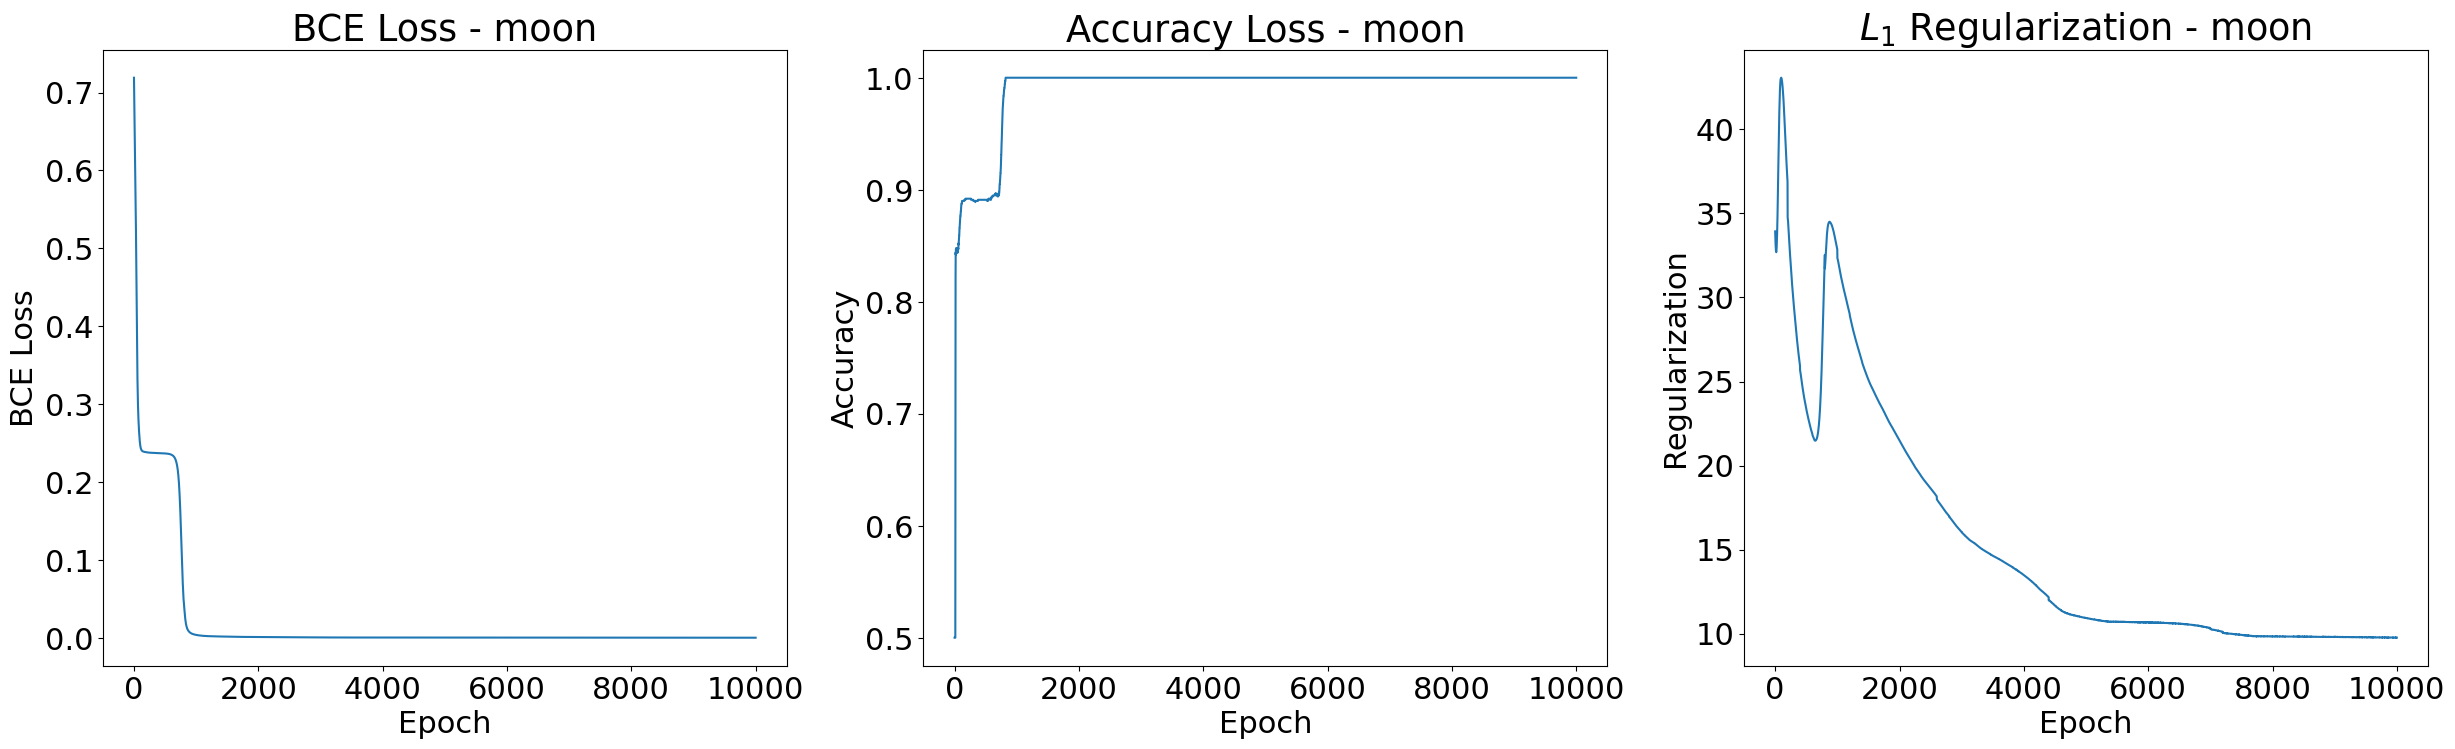

In [183]:
import os

model_name = "bimt"
dataset_name = "moon"
size = "vanilla"
list_models = os.listdir(f"models/supervised/{model_name}/saved_models/{size}/{dataset_name}")
list_models = [int(x.split("_")[1].split(".")[0]) for x in list_models if x.endswith(".pth")]
list_models = sorted(list_models)
with open(f'models/supervised/{model_name}/saved_models/{size}/{dataset_name}/dataset.pkl', 'rb') as f:
    dataset = pkl.load(f)
#model_base = MLP(2,7,4,4)
model_base = BioMLP(shp=[2,20,20,2])
plot_bce_loss_acc(dataset, model_base, list_models, model_name, size, dataset_name)

In [142]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def compute_mig(mu, generative_factors):
    """
    Compute the Mutual Information Gap (MIG) between the latent variables and generative factors.
    
    Parameters:
    - mu: Latent variables from the VAE (shape: [num_samples, num_latents])
    - generative_factors: True generative factors (shape: [num_samples, num_factors])
    
    Returns:
    - MIG score
    """
    num_latents = mu.shape[1]
    num_factors = generative_factors.shape[1]
    
    # Compute mutual information between each latent and each factor
    mi_matrix = np.zeros((num_latents, num_factors))
    for i in range(num_latents):
        for j in range(num_factors):
            mi = mutual_info_regression(mu[:, i].reshape(-1, 1), generative_factors[:, j])
            mi_matrix[i, j] = mi[0]
    
    # Sort the MI for each factor
    sorted_mi = np.sort(mi_matrix, axis=0)[::-1]
    
    # Compute MIG
    mig = np.mean(sorted_mi[0, :] - sorted_mi[1, :])
    
    return mig

def compute_sap(mu, generative_factors):
    """
    Compute the SAP score between the latent variables and generative factors.
    
    Parameters:
    - mu: Latent variables from the VAE (shape: [num_samples, num_latents])
    - generative_factors: True generative factors (shape: [num_samples, num_factors])
    
    Returns:
    - SAP score
    """
    num_latents = mu.shape[1]
    num_factors = generative_factors.shape[1]
    
    # Compute pointwise mutual information (PMI) between each latent and each factor
    pmi_matrix = np.zeros((num_latents, num_factors))
    for i in range(num_latents):
        for j in range(num_factors):
            mi = mutual_info_regression(mu[:, i].reshape(-1, 1), generative_factors[:, j])
            h_y = -np.sum(generative_factors[:, j] * np.log(generative_factors[:, j] + 1e-10))
            pmi_matrix[i, j] = mi[0] / h_y
    
    # Compute SAP score as the max PMI for each factor
    sap_score = np.mean(np.max(pmi_matrix, axis=0))
    
    return sap_score

def compute_dci(mu, generative_factors):
    """
    Compute the DCI (Disentanglement, Completeness, Informativeness) between the latent variables and generative factors.
    
    Parameters:
    - mu: Latent variables from the VAE (shape: [num_samples, num_latents])
    - generative_factors: True generative factors (shape: [num_samples, num_factors])
    
    Returns:
    - A tuple containing (Disentanglement, Completeness, Informativeness)
    """
    num_latents = mu.shape[1]
    num_factors = generative_factors.shape[1]
    
    # Compute mutual information between each latent and each factor
    mi_matrix = np.zeros((num_latents, num_factors))
    for i in range(num_latents):
        for j in range(num_factors):
            mi = mutual_info_regression(mu[:, i].reshape(-1, 1), generative_factors[:, j])
            mi_matrix[i, j] = mi[0]
    
    # Compute disentanglement as the sum of max MI for each latent
    disentanglement = np.sum(np.max(mi_matrix, axis=1))
    
    # Compute completeness as the sum of max MI for each factor
    completeness = np.sum(np.max(mi_matrix, axis=0))
    
    # Compute informativeness as the sum of all MI
    informativeness = np.sum(mi_matrix)
    
    return disentanglement, completeness, informativeness

def generate_latents_and_factors(model, dataset, device='cpu'):
    """
    Generate latent variables and corresponding generative factors using a trained VAE model and a dataset.
    
    Parameters:
    - model: Trained VAE model.
    - dataset: Dataset object with generative factors.
    - device: Device to run the model on ('cpu' or 'cuda').
    
    Returns:
    - mu: Latent variables from the VAE (shape: [num_samples, num_latents])
    - generative_factors: True generative factors (shape: [num_samples, num_factors])
    """
    model = model.to(device)
    model.eval()
    
    all_mu = []
    all_factors = []
    
    for i in range(len(dataset)):
        sample, factors = dataset[i]
        sample = sample.to(device).float().unsqueeze(0)
        
        with torch.no_grad():
            _, mu, _ = model(sample)
        
        all_mu.append(mu.cpu().numpy())
        all_factors.append(factors.cpu().numpy())
    
    mu = np.vstack(all_mu)
    generative_factors = np.vstack(all_factors)
    
    return mu, generative_factors









In [152]:
from models.unsupervised.vae.model import Encoder, Decoder, VAE
# Dummy VAE model and dataset for testing
encoder = Encoder(in_features=32, features=[64, 32, 16, 8, 4], out_features=2)
decoder = Decoder(in_features=2, features=[4, 8, 16, 32, 64], out_features=32)
vae = VAE(encoder, decoder)


In [157]:
import os
from tqdm import tqdm
model_name = "vae"
dataset_name = "moon"
size = "disentangled_5"
list_models = os.listdir(f"models/unsupervised/{model_name}/saved_models/{size}")
list_models = [int(x.split("_")[1].split(".")[0]) for x in list_models if x.endswith(".pth")]
list_models = sorted(list_models)
with open(f'models/unsupervised/{model_name}/saved_models/{size}/dataset.pkl', 'rb') as f:
    dataset = pkl.load(f)

store_dci = []
store_sap = []
store_mig = []
for epoch in tqdm(list_models):
    vae.load_state_dict(torch.load(f"models/unsupervised/{model_name}/saved_models/{size}/model_{epoch}.pth"))
    vae.eval()
    mu, generative_factors = generate_latents_and_factors(vae, dataset)
    dci = compute_dci(mu, generative_factors)
    sap = compute_sap(mu, generative_factors)
    mig = compute_mig(mu, generative_factors)
    store_dci.append(dci)
    store_sap.append(sap)
    store_mig.append(mig)


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:36<00:00,  1.13s/it]


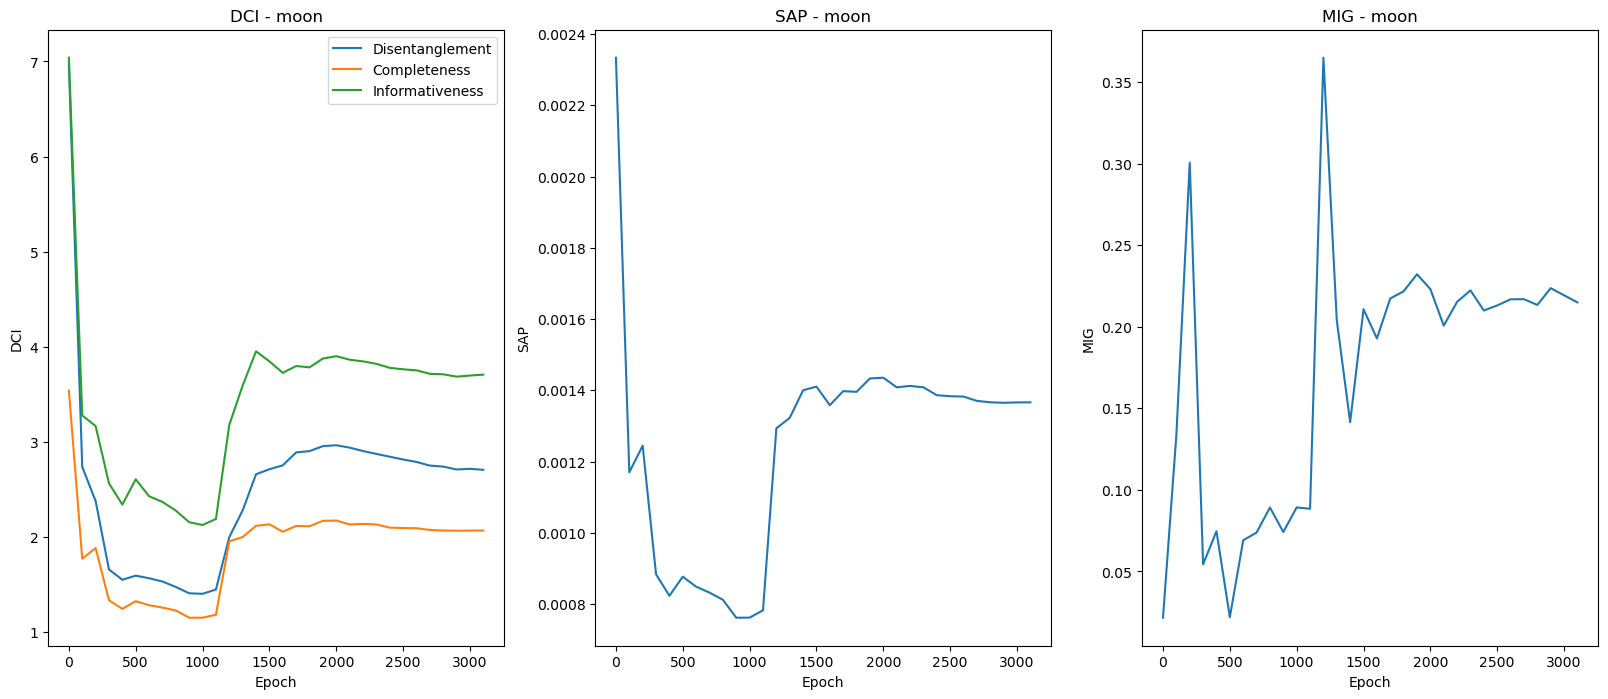

In [158]:
store_dci = np.array(store_dci)

fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].plot(list_models, store_dci[:, 0], label="Disentanglement")
ax[0].plot(list_models, store_dci[:, 1], label="Completeness")
ax[0].plot(list_models, store_dci[:, 2], label="Informativeness")
ax[0].set_title(f"DCI - {dataset_name}")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("DCI")
ax[0].legend()

ax[1].plot(list_models, store_sap)
ax[1].set_title(f"SAP - {dataset_name}")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("SAP")

ax[2].plot(list_models, store_mig)
ax[2].set_title(f"MIG - {dataset_name}")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("MIG")

fig.savefig(f"models/metrics/{model_name}_{size}_{dataset_name}_fig.png", bbox_inches='tight')